In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-11-28 07:53:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2021-11-28 07:53:02 (7.39 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [3]:
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.45500,123.65499,125.75850,123.63383
2,BTC,2013-10-03,108.58483,125.45500,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.67500,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566


In [8]:
df.tail()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
2782,BTC,2021-05-14,49764.132082,49596.778891,51448.798576,46294.720180
2783,BTC,2021-05-15,50032.693137,49717.354353,51578.312545,48944.346536
2784,BTC,2021-05-16,47885.625255,49926.035067,50690.802950,47005.102292
2785,BTC,2021-05-17,45604.615754,46805.537852,49670.414174,43868.638969
2786,BTC,2021-05-18,43144.471291,46439.336570,46622.853437,42102.346430


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2787 entries, 0 to 2786
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Date                 2787 non-null   object 
 2   Closing Price (USD)  2787 non-null   float64
 3   24h Open (USD)       2787 non-null   float64
 4   24h High (USD)       2787 non-null   float64
 5   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(2)
memory usage: 130.8+ KB


In [7]:
df.shape

(2787, 6)

In [9]:
len(df)

2787

In [4]:
time_step = [i for i in range(len(df))]

In [13]:
len(time_step)

2787

In [5]:
import csv
close_price = []

with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        close_price.append(float(row[2]))

In [16]:
len(close_price)

2787

In [17]:
time_step[0], time_step[-1]

(0, 2786)

In [18]:
close_price[0], close_price[-1]

(123.65499, 43144.4712908603)

In [6]:
series = np.array(close_price)
time = np.array(time_step)

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

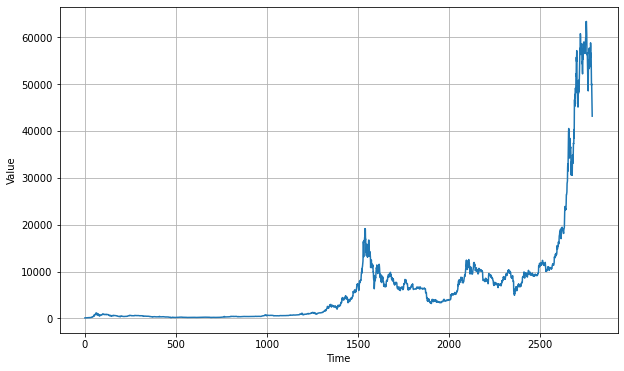

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [22]:
series[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [23]:
time[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
SPLIT_TIME = 2200
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

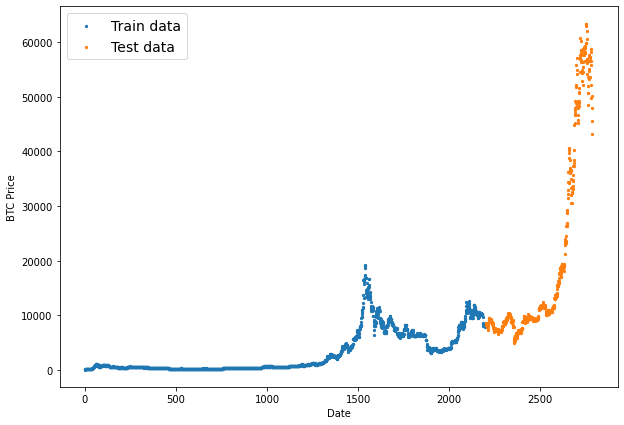

In [25]:
plt.figure(figsize=(10, 7))
plt.scatter(time_train, x_train, s=5, label="Train data")
plt.scatter(time_valid, x_valid, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

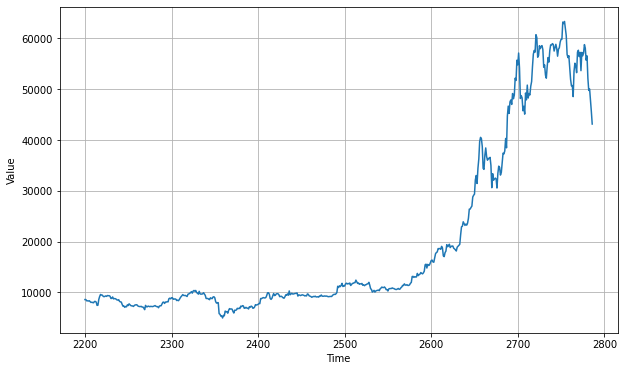

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [10]:
WINDOW_SIZE = 7                              # 7 days, each time slice is a day
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [12]:
tf.random.set_seed(51)
np.random.seed(51)

In [13]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

## Dense

In [41]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),                
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                160       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [42]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [43]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [44]:
early_stopping    = EarlyStopping(monitor='loss', patience=40)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [45]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [46]:
EPOCHS = 120
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [47]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/120
69/69 [==============================] - 1s 8ms/step - loss: 2996.9724 - mae: 2997.4724 - lr: 1.0000e-08
Epoch 2/120
69/69 [==============================] - 1s 7ms/step - loss: 2199.9050 - mae: 2200.4050 - lr: 1.1220e-08
Epoch 3/120
69/69 [==============================] - 1s 8ms/step - loss: 1282.8693 - mae: 1283.3693 - lr: 1.2589e-08
Epoch 4/120
69/69 [==============================] - 1s 7ms/step - loss: 362.9659 - mae: 363.4653 - lr: 1.4125e-08
Epoch 5/120
69/69 [==============================] - 1s 7ms/step - loss: 229.8137 - mae: 230.3108 - lr: 1.5849e-08
Epoch 6/120
69/69 [==============================] - 1s 7ms/step - loss: 227.4941 - mae: 227.9893 - lr: 1.7783e-08
Epoch 7/120
69/69 [==============================] - 1s 7ms/step - loss: 225.2660 - mae: 225.7608 - lr: 1.9953e-08
Epoch 8/120
69/69 [==============================] - 1s 7ms/step - loss: 224.5491 - mae: 225.0434 - lr: 2.2387e-08
Epoch 9/120
69/69 [==============================] - 1s 7ms/step - loss: 2

(1e-08, 0.0001, 100.0, 500.0)

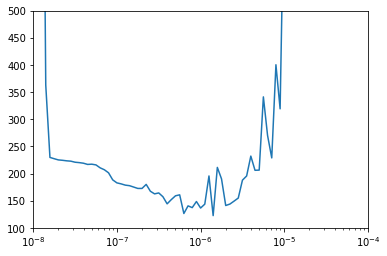

In [51]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 100, 500])

In [52]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),                
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [53]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1.4125e-06, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [54]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [55]:
early_stopping    = EarlyStopping(monitor='loss', patience=70)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [56]:
EPOCHS = 400
CALLBACKS = [early_stopping, model_checkpoint]

In [57]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/400
69/69 [==============================] - 1s 9ms/step - loss: 1053.6420 - mae: 1054.1414
Epoch 2/400
69/69 [==============================] - 1s 8ms/step - loss: 211.9368 - mae: 212.4346
Epoch 3/400
69/69 [==============================] - 1s 8ms/step - loss: 159.7281 - mae: 160.2243
Epoch 4/400
69/69 [==============================] - 1s 7ms/step - loss: 161.5264 - mae: 162.0239
Epoch 5/400
69/69 [==============================] - 1s 8ms/step - loss: 141.9611 - mae: 142.4557
Epoch 6/400
69/69 [==============================] - 1s 8ms/step - loss: 147.7801 - mae: 148.2762
Epoch 7/400
69/69 [==============================] - 1s 8ms/step - loss: 146.6385 - mae: 147.1329
Epoch 8/400
69/69 [==============================] - 1s 8ms/step - loss: 133.7258 - mae: 134.2224
Epoch 9/400
69/69 [==============================] - 1s 7ms/step - loss: 128.9578 - mae: 129.4523
Epoch 10/400
69/69 [==============================] - 1s 7ms/step - loss: 132.2226 - mae: 132.7178
Epoch 11/400
69/6

<function matplotlib.pyplot.show>

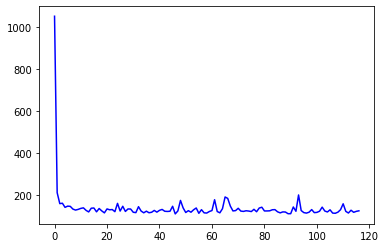

In [58]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show

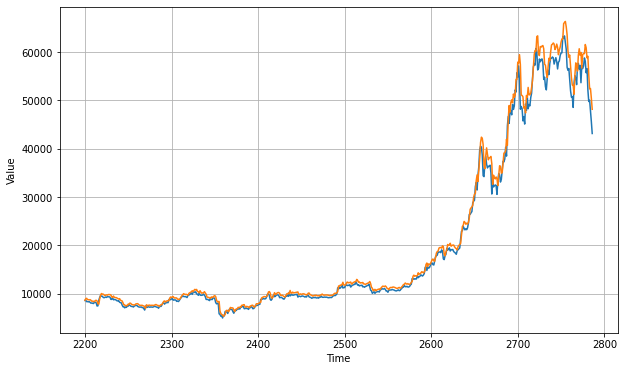

In [59]:
forecast=[]

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [60]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1001.46484

In [61]:
best_model = tf.keras.models.load_model('best_model.h5')

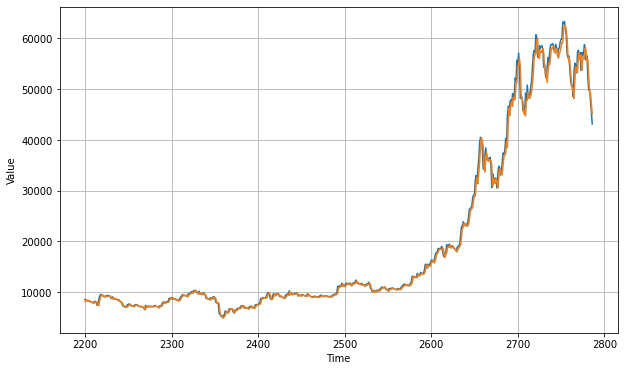

In [62]:
forecast=[]

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(best_model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [63]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

608.18335

## Conv1D

In [75]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE, 1]),           
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(20, activation="relu"),
    layers.Dense(1)
])

In [84]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 7, 32)             192       
                                                                 
 dense_11 (Dense)            (None, 7, 20)             660       
                                                                 
 dense_12 (Dense)            (None, 7, 1)              21        
                                                                 
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


In [76]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [77]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [78]:
early_stopping    = EarlyStopping(monitor='loss', patience=40)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [79]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [80]:
EPOCHS = 120
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [81]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/120
69/69 [==============================] - 2s 10ms/step - loss: 3064.4766 - mae: 3064.9761 - lr: 1.0000e-08
Epoch 2/120
69/69 [==============================] - 1s 9ms/step - loss: 2980.1230 - mae: 2980.6230 - lr: 1.1220e-08
Epoch 3/120
69/69 [==============================] - 1s 10ms/step - loss: 2926.3738 - mae: 2926.8738 - lr: 1.2589e-08
Epoch 4/120
69/69 [==============================] - 1s 9ms/step - loss: 2885.7983 - mae: 2886.2983 - lr: 1.4125e-08
Epoch 5/120
69/69 [==============================] - 1s 9ms/step - loss: 2856.7510 - mae: 2857.2512 - lr: 1.5849e-08
Epoch 6/120
69/69 [==============================] - 1s 9ms/step - loss: 2834.0869 - mae: 2834.5859 - lr: 1.7783e-08
Epoch 7/120
69/69 [==============================] - 1s 9ms/step - loss: 2820.1594 - mae: 2820.6589 - lr: 1.9953e-08
Epoch 8/120
69/69 [==============================] - 1s 9ms/step - loss: 2806.9551 - mae: 2807.4551 - lr: 2.2387e-08
Epoch 9/120
69/69 [==============================] - 1s 9ms/st

(1e-08, 0.0001, 2000.0, 4000.0)

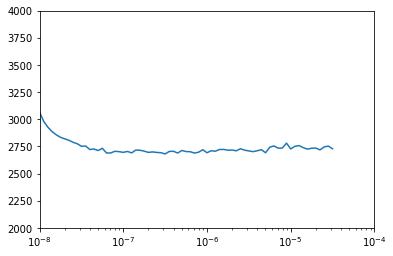

In [83]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 2000, 4000])

## BiLSTM

In [92]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE, 1]),           
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(20, activation="relu"),
    layers.Dense(1)
])

In [93]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [94]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [95]:
early_stopping    = EarlyStopping(monitor='loss', patience=40)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [96]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [97]:
EPOCHS = 120
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [98]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/120
69/69 [==============================] - 9s 16ms/step - loss: 3080.3459 - mae: 3080.8459 - lr: 1.0000e-08
Epoch 2/120
69/69 [==============================] - 1s 16ms/step - loss: 3080.3455 - mae: 3080.8455 - lr: 1.1220e-08
Epoch 3/120
69/69 [==============================] - 1s 15ms/step - loss: 3080.3445 - mae: 3080.8445 - lr: 1.2589e-08
Epoch 4/120
69/69 [==============================] - 1s 15ms/step - loss: 3080.3435 - mae: 3080.8435 - lr: 1.4125e-08
Epoch 5/120
69/69 [==============================] - 1s 16ms/step - loss: 3080.3413 - mae: 3080.8413 - lr: 1.5849e-08
Epoch 6/120
69/69 [==============================] - 1s 16ms/step - loss: 3080.3381 - mae: 3080.8381 - lr: 1.7783e-08
Epoch 7/120
69/69 [==============================] - 1s 15ms/step - loss: 3080.3342 - mae: 3080.8342 - lr: 1.9953e-08
Epoch 8/120
69/69 [==============================] - 1s 16ms/step - loss: 3080.3333 - mae: 3080.8333 - lr: 2.2387e-08
Epoch 9/120
69/69 [==============================] - 1s 

(1e-08, 0.01, 2500.0, 3500.0)

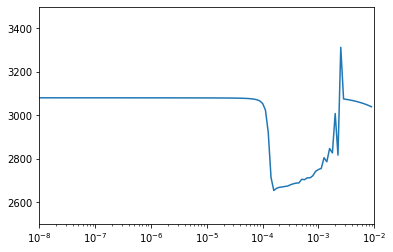

In [101]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-2, 2500, 3500])

## Conv1D + BiLSTM

In [15]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE, 1]),      
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),  
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),        
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 7, 32)             192       
                                                                 
 bidirectional_2 (Bidirectio  (None, 7, 64)            16640     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 20)                1300      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                

In [17]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [18]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [19]:
early_stopping    = EarlyStopping(monitor='loss', patience=40)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [20]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [21]:
EPOCHS = 120
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [22]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/120
69/69 [==============================] - 18s 20ms/step - loss: 3080.2434 - mae: 3080.7434 - lr: 1.0000e-08
Epoch 2/120
69/69 [==============================] - 1s 18ms/step - loss: 3080.2424 - mae: 3080.7424 - lr: 1.1220e-08
Epoch 3/120
69/69 [==============================] - 2s 19ms/step - loss: 3080.2415 - mae: 3080.7415 - lr: 1.2589e-08
Epoch 4/120
69/69 [==============================] - 2s 19ms/step - loss: 3080.2415 - mae: 3080.7415 - lr: 1.4125e-08
Epoch 5/120
69/69 [==============================] - 2s 19ms/step - loss: 3080.2397 - mae: 3080.7397 - lr: 1.5849e-08
Epoch 6/120
69/69 [==============================] - 2s 20ms/step - loss: 3080.2383 - mae: 3080.7383 - lr: 1.7783e-08
Epoch 7/120
69/69 [==============================] - 1s 19ms/step - loss: 3080.2378 - mae: 3080.7378 - lr: 1.9953e-08
Epoch 8/120
69/69 [==============================] - 2s 20ms/step - loss: 3080.2366 - mae: 3080.7366 - lr: 2.2387e-08
Epoch 9/120
69/69 [==============================] - 2s

(1e-08, 0.01, 2400.0, 3300.0)

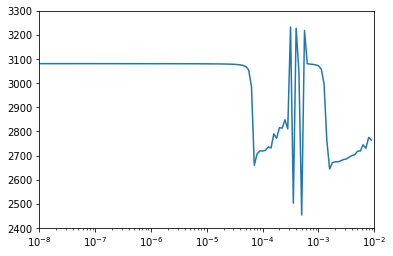

In [26]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-2, 2400, 3300])

## Dense + SGD

In [27]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]), 
    layers.Dense(30, activation="relu"),               
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                240       
                                                                 
 dense_7 (Dense)             (None, 20)                620       
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


In [29]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [30]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [31]:
early_stopping    = EarlyStopping(monitor='loss', patience=40)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [32]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [33]:
EPOCHS = 120
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [34]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/120
69/69 [==============================] - 1s 10ms/step - loss: 3025.6570 - mae: 3026.1570 - lr: 1.0000e-08
Epoch 2/120
69/69 [==============================] - 1s 8ms/step - loss: 2663.8616 - mae: 2664.3616 - lr: 1.1220e-08
Epoch 3/120
69/69 [==============================] - 1s 8ms/step - loss: 2438.1440 - mae: 2438.6440 - lr: 1.2589e-08
Epoch 4/120
69/69 [==============================] - 1s 8ms/step - loss: 2178.9563 - mae: 2179.4563 - lr: 1.4125e-08
Epoch 5/120
69/69 [==============================] - 1s 9ms/step - loss: 1759.3052 - mae: 1759.8052 - lr: 1.5849e-08
Epoch 6/120
69/69 [==============================] - 1s 9ms/step - loss: 1202.8264 - mae: 1203.3264 - lr: 1.7783e-08
Epoch 7/120
69/69 [==============================] - 1s 9ms/step - loss: 441.5605 - mae: 442.0601 - lr: 1.9953e-08
Epoch 8/120
69/69 [==============================] - 1s 8ms/step - loss: 154.9899 - mae: 155.4838 - lr: 2.2387e-08
Epoch 9/120
69/69 [==============================] - 1s 9ms/step - 

(1e-08, 0.0001, 100.0, 1000.0)

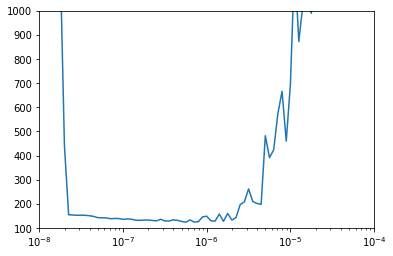

In [36]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 100, 1000])

In [37]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]), 
    layers.Dense(30, activation="relu"),               
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [38]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=5.6234e-07, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [39]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [40]:
early_stopping    = EarlyStopping(monitor='loss', patience=70)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [41]:
EPOCHS = 400
CALLBACKS = [early_stopping, model_checkpoint]

In [42]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/400
69/69 [==============================] - 1s 9ms/step - loss: 603.8174 - mae: 604.3167
Epoch 2/400
69/69 [==============================] - 1s 9ms/step - loss: 165.1748 - mae: 165.6706
Epoch 3/400
69/69 [==============================] - 1s 9ms/step - loss: 149.6938 - mae: 150.1894
Epoch 4/400
69/69 [==============================] - 1s 9ms/step - loss: 139.5124 - mae: 140.0074
Epoch 5/400
69/69 [==============================] - 1s 8ms/step - loss: 157.6649 - mae: 158.1618
Epoch 6/400
69/69 [==============================] - 1s 9ms/step - loss: 132.9671 - mae: 133.4596
Epoch 7/400
69/69 [==============================] - 1s 8ms/step - loss: 142.7677 - mae: 143.2646
Epoch 8/400
69/69 [==============================] - 1s 9ms/step - loss: 141.4660 - mae: 141.9621
Epoch 9/400
69/69 [==============================] - 1s 10ms/step - loss: 127.9479 - mae: 128.4428
Epoch 10/400
69/69 [==============================] - 1s 8ms/step - loss: 133.1796 - mae: 133.6759
Epoch 11/400
69/69

<function matplotlib.pyplot.show>

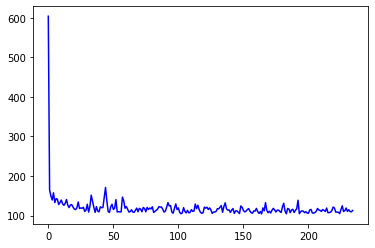

In [43]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show

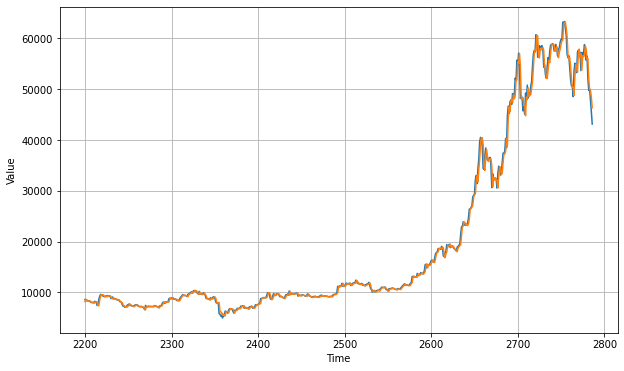

In [44]:
forecast=[]

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

559.68396

In [46]:
best_model = tf.keras.models.load_model('best_model.h5')

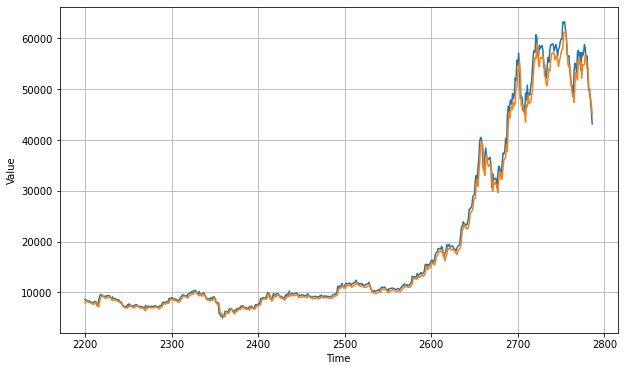

In [47]:
forecast=[]

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(best_model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [48]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

840.39685

## Dense + Adam

In [77]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]), 
    layers.Dense(40, activation="relu"),               
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 40)                320       
                                                                 
 dense_19 (Dense)            (None, 20)                820       
                                                                 
 dense_20 (Dense)            (None, 10)                210       
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [78]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=1e-7)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [79]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [80]:
early_stopping    = EarlyStopping(monitor='loss', patience=40)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [81]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

In [82]:
EPOCHS = 120
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [83]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/120
69/69 [==============================] - 2s 10ms/step - loss: 2580.3704 - mae: 2580.8704 - lr: 1.0000e-07
Epoch 2/120
69/69 [==============================] - 1s 10ms/step - loss: 2579.8811 - mae: 2580.3811 - lr: 1.1220e-07
Epoch 3/120
69/69 [==============================] - 1s 9ms/step - loss: 2579.3569 - mae: 2579.8569 - lr: 1.2589e-07
Epoch 4/120
69/69 [==============================] - 1s 9ms/step - loss: 2578.7771 - mae: 2579.2771 - lr: 1.4125e-07
Epoch 5/120
69/69 [==============================] - 1s 9ms/step - loss: 2578.1304 - mae: 2578.6304 - lr: 1.5849e-07
Epoch 6/120
69/69 [==============================] - 1s 9ms/step - loss: 2577.4075 - mae: 2577.9075 - lr: 1.7783e-07
Epoch 7/120
69/69 [==============================] - 1s 9ms/step - loss: 2576.5925 - mae: 2577.0925 - lr: 1.9953e-07
Epoch 8/120
69/69 [==============================] - 1s 9ms/step - loss: 2575.6753 - mae: 2576.1753 - lr: 2.2387e-07
Epoch 9/120
69/69 [==============================] - 1s 9ms/st

(1e-05, 0.01, 100.0, 500.0)

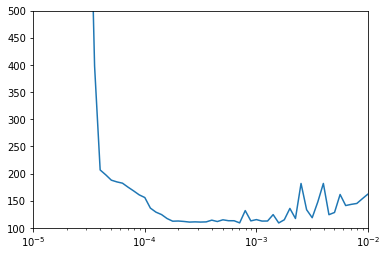

In [84]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-5, 1e-2, 100, 500])

In [85]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]), 
    layers.Dense(40, activation="relu"),               
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [86]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=7.0795e-04)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [87]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [88]:
early_stopping    = EarlyStopping(monitor='loss', patience=70)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [89]:
EPOCHS = 400
CALLBACKS = [early_stopping, model_checkpoint]

In [90]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/400
69/69 [==============================] - 2s 9ms/step - loss: 405.2981 - mae: 405.7967
Epoch 2/400
69/69 [==============================] - 1s 9ms/step - loss: 207.5301 - mae: 208.0264
Epoch 3/400
69/69 [==============================] - 1s 9ms/step - loss: 193.7712 - mae: 194.2680
Epoch 4/400
69/69 [==============================] - 1s 10ms/step - loss: 177.1356 - mae: 177.6299
Epoch 5/400
69/69 [==============================] - 1s 10ms/step - loss: 168.1788 - mae: 168.6747
Epoch 6/400
69/69 [==============================] - 1s 9ms/step - loss: 191.9850 - mae: 192.4828
Epoch 7/400
69/69 [==============================] - 1s 9ms/step - loss: 150.9610 - mae: 151.4550
Epoch 8/400
69/69 [==============================] - 1s 8ms/step - loss: 143.9775 - mae: 144.4709
Epoch 9/400
69/69 [==============================] - 1s 10ms/step - loss: 136.5240 - mae: 137.0170
Epoch 10/400
69/69 [==============================] - 1s 9ms/step - loss: 140.5431 - mae: 141.0390
Epoch 11/400
69/

<function matplotlib.pyplot.show>

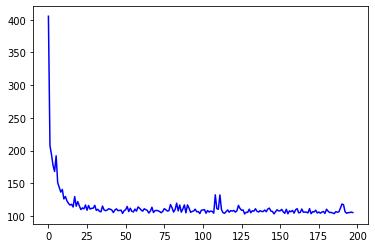

In [91]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show

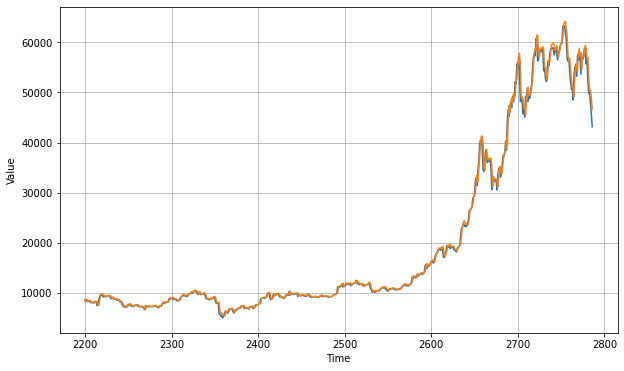

In [92]:
forecast=[]

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [93]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

581.6071

In [94]:
best_model = tf.keras.models.load_model('best_model.h5')

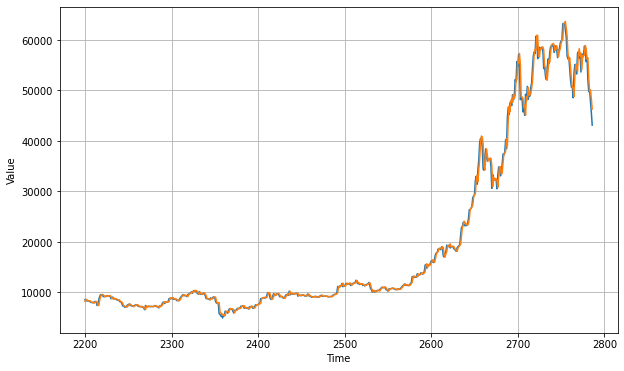

In [95]:
forecast=[]

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(best_model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [96]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

549.76605